In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, mpld3
import os
import fnmatch
import csv
import pickle
import warnings
import torch
import time

warnings.filterwarnings('ignore')

### Required for building NN ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from termcolor import colored
import tensorflow.keras.backend as K

### Create architecture

In [2]:
def make_model(inputs, n_outputs):

    hidden_layer_1 = tf.layers.dense(inputs, 10, activation=tf.nn.leaky_relu)
    hidden_layer_2 = tf.layers.dense(hidden_layer_1, 15, activation=tf.nn.sigmoid)
    hidden_layer_3 = tf.layers.dense(hidden_layer_2, 10, activation=tf.nn.sigmoid)
    #hidden_layer_4 = tf.layers.dense(hidden_layer_3, 5, activation=tf.nn.sigmoid)
    hidden_layer_3 = tf.layers.dropout(hidden_layer_3, 0.05)
    output = tf.layers.dense(hidden_layer_3, n_outputs, name='outputs', reuse=tf.AUTO_REUSE)

    return output



### Prepare data for training

Cost function: $\chi^2 = 1/N \sum (y - y_{pred})^2 / \sigma^2$ \
Optimizer: AdamOptimizer, $\eta = 0.02$\

Training points are generated by Monte Carlo sampling; for the set of training points $[dE, D_i, \sigma_i]$, a set of MC training points is generated by adding a stochastic noise signal on top of the the data with a std equal to the corresponding error on that point. 

- **train_x**: $[dE, t_{exp}]$
- **train_y**: $D_i$ + rand.norm(0, $\sigma_i$)

Repetitive training of the NN (number of repetitions = $N_{rep}$) on each set of MC pseudo data yields a prediction that is distributed with a mean and std corresponding to the mean and error of the original training set. 


In [3]:
tf.reset_default_graph()
from copy import copy
from sklearn.model_selection import train_test_split

x = tf.placeholder("float", [None, 3])
y = tf.placeholder("float", [None, 1])
sigma = tf.placeholder("float", [None, 1])

df_train_full = pd.read_csv('Data/Apr/training_merged_3.csv', header=0)
df_train, df_test = train_test_split(df_train_full, test_size=0.15)

train_x = np.array(df_train[['x', 'time', 'energy']].to_numpy())
N_train = len(train_x[:,0])
train_y = np.copy(df_train['y']).reshape(N_train,1)
train_sigma = np.copy(df_train['sigma']).reshape(N_train,1)

test_x = np.array(df_test[['x', 'time', 'energy']].to_numpy())
N_test = len(test_x[:,0])
test_y = np.copy(df_test['y']).reshape(N_test,1)
test_sigma = np.copy(df_test['sigma']).reshape(N_test,1)


predictions = make_model(x,1)




Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dropout instead.


## Set a restriction for the minimum relative error

In [4]:
relative_error = np.divide(train_sigma, train_y)
treshold = 0.001
treshold_error_index = np.where(relative_error > treshold)[0]
train_x, train_y, train_sigma = train_x[treshold_error_index], train_y[treshold_error_index], train_sigma[treshold_error_index]
N_train = len(train_x)

relative_error = np.divide(test_sigma, test_y)
treshold_error_index = np.where(relative_error > treshold)[0]
test_x, test_y, test_sigma = test_x[treshold_error_index], test_y[treshold_error_index], test_sigma[treshold_error_index]
N_test = len(test_x)

print(train_x[0])

[-0.5712141  0.1        2.       ]


## Create MC replicas

In [5]:
### Create array of Nrep training samples
Nrep = 1000
#pbar = tqdm(total=Nrep)
train_y_reps = np.zeros(shape=(N_train, Nrep))
test_y_reps = np.zeros(shape=(N_test, Nrep))
i=0
while i < Nrep:
    train_rep = np.random.normal(0, train_sigma)
    test_rep = np.random.normal(0, test_sigma)
    train_y_reps[:,i] = (train_y + train_rep).reshape(N_train)
    test_y_reps[:,i] = (test_y + test_rep).reshape(N_test)
    i+=1 
train_y_reps[train_y_reps < .1] = .1    
test_y_reps[test_y_reps < .1] = .1
std_reps = np.std(train_y_reps, axis=1)
mean_reps = np.mean(train_y_reps, axis=1)

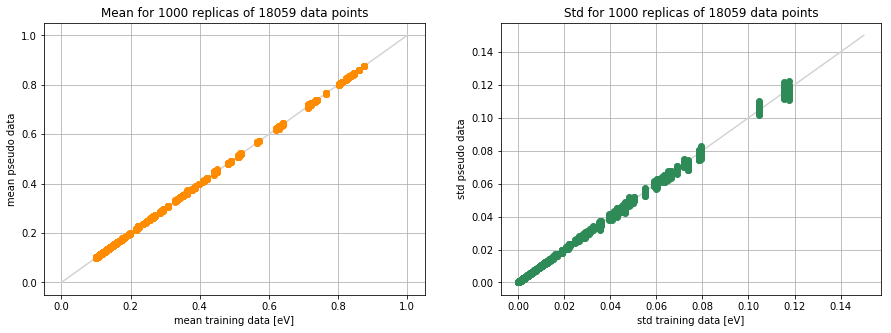

In [6]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.title('Mean for %(Nrep)s replicas of %(N_train)s data points' % {"Nrep": Nrep, "N_train": N_train})
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), color='lightgrey')
plt.plot(train_y, mean_reps, 'o', color = 'darkorange', label = 'Predictions pseudodata')
plt.grid(True)
plt.xlabel(r'mean training data [eV]')
plt.ylabel(r'mean pseudo data')

plt.subplot(122)
plt.grid(True)
plt.title('Std for %(Nrep)s replicas of %(N_train)s data points' % {"Nrep": Nrep, "N_train": N_train})
plt.plot(np.linspace(0,0.15,10), np.linspace(0,0.15,10), color='lightgrey')
plt.plot(train_sigma, std_reps, 'o', color='seagreen', label = 'Predictions pseudodata')
plt.xlabel(r'std training data [eV]')
plt.ylabel(r'std pseudo data')

plt.show()

In [18]:
## Beam energy interpolation

import random
N_pred = 2000
part1 = 1000
interpol_energy1 = 1.5 #*100 keV
interpol_energy2 = 2.5 #*100 keV

predict_x = np.zeros(shape=(N_pred, 3))
predict_x[:part1,0] = np.linspace(-1,1,part1)
predict_x[part1:, 0] = np.linspace(-1,1,N_pred-part1)
predict_x[:,1] = 1 * np.ones(N_pred)
predict_x[:part1,2] = interpol_energy1 * np.ones(part1)
predict_x[part1:,2] = interpol_energy2 * np.ones(N_pred-part1)


In [19]:
import time
from datetime import datetime

training_epochs = 50000
max_rising_epochs = 5000 #The amount of epochs the minimzer is allowed to overfit before it stops
display_step = 1000
chi_array = []

tic = time.time()

### Define cost and optimizer
cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="cost_function")
custom_cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="custom_cost_function")
eta = 3e-2
optimizer = tf.train.AdamOptimizer(learning_rate=eta, beta1=0.9, beta2=0.999, epsilon=1e-08).minimize(cost)

i = 0
Nrep = 20

while i < (Nrep):
    
    """Training data: train_y = D_i + rand.norm(0, sigma_i);
    use train_y = gaus_y + rand.norm(0, sigma_i) in case of Closure testing"""
    
    train_y = train_y_reps[:,i].reshape(N_train,1)
    test_y = test_y_reps[:,i].reshape(N_test,1)

    ### Train and validate
    prev_test_cost = 100
    prev_epoch=0
    avg_cost = 0.0

    array_train = []
    array_test = []
    
    print("Start training on", '%04d' %(N_train), "and validating on", '%0.4d' %(N_test), "samples")

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        

        for epoch in range(training_epochs):

            _, c = sess.run([optimizer, cost], 
                            feed_dict={
                                x: train_x,
                                y: train_y,
                                sigma: train_sigma
                            })
            avg_cost = c 

            test_cost = cost.eval({x: test_x, y: test_y, sigma: test_sigma})


            if epoch % display_step == 0:
                print("Epoch:", '%04d' % (epoch+1), "| Training cost=", "{:.9f}".format(avg_cost), "| Validation cost=", "{:.9f}".format(test_cost))
                array_train.append(avg_cost)
                array_test.append(test_cost)
            
            if avg_cost < 1.10 and test_cost < 1.2:
                print("Fine outcome")
                break

            if test_cost >= prev_test_cost and epoch-prev_epoch >= max_rising_epochs:
                print(colored("\n The session stopped because of overfitting...","red"))
                print("Start overfitting at epoch:", '%04d' % (epoch), "| Validation cost =", "{:.9f}".format(test_cost), "| Train cost=", "{:.9f}".format(avg_cost))
                break
        
            elif test_cost < prev_test_cost:
                prev_test_cost = test_cost
                prev_epoch = epoch


        print("Optimization Finished!")
        
        predictions_values = sess.run(predictions, 
                            feed_dict={
                                x: train_x,
                                y: train_y 
                            }) 
        
        extrapolation = sess.run(predictions,
                            feed_dict={
                                x: predict_x
                            })
    
    sess.close()

    # save to csv file
    predictions_values = predictions_values.reshape(N_train,)
    toc = time.time()
    print("Elapsed time:", toc-tic)
    
    now = datetime.now()
  
    dt_string = now.strftime("%d.%m.%Y %H:%M:%S")
    d_string = now.strftime("%d.%m.%Y")
    t_string = now.strftime("%H:%M:%S")

    #foot = np.array(seednumber)
    a = np.array(train_x[:,0])
    b = np.array(train_y)
    c = np.array(predictions_values)
    d = array_train
    e = array_test
    g = np.array(train_x[:,1])
    h = np.array(train_x[:,2])
    k1 = np.array(predict_x[:,0])
    k2 = np.array(predict_x[:,1])
    k3 = np.array(predict_x[:,2])
    l = np.array(extrapolation)
    
    
    chi_array.append(d[-1])

    best_chi = np.where(array_test == min(array_test))
    
    if d[-1] < 1.3:
        np.savetxt('Data/Results/%(date)s/xyp1p2_all_e%(epoch)s_round3_%(i)s.csv' % {"date": d_string, "epoch": training_epochs, "i": i }, list(zip(a,b,c,g,h)),  delimiter=',',  header="best iteration: %(p)s" % {"p": best_chi}, fmt='%f')
        np.savetxt('Data/Results/%(date)s/chi_all_e%(epoch)s_round3_%(i)s.csv' % {"date": d_string, "epoch": training_epochs, "i": i }, list(zip(d,e)),  delimiter=',',  header="best iteration: %(p)s" % {"p": best_chi}, fmt='%f')
        np.savetxt('Data/Results/%(date)s/extrapolation_e%(epoch)s_round3_%(i)s.csv' % {"date": d_string, "epoch": training_epochs, "i": i }, list(zip(k1, k2, k3, l)),  delimiter=',',  header="best iteration: %(p)s" % {"p": best_chi}, fmt='%f')
 
    print(i)
    i+=1

Start training on 18059 and validating on 3212 samples
Epoch: 0001 | Training cost= 8909757.000000000 | Validation cost= 4224662.000000000
Epoch: 1001 | Training cost= 22.630203247 | Validation cost= 25.531698227
Epoch: 2001 | Training cost= 18.240070343 | Validation cost= 21.472732544
Epoch: 3001 | Training cost= 17.002956390 | Validation cost= 20.197246552
Epoch: 4001 | Training cost= 16.529350281 | Validation cost= 19.603717804
Epoch: 5001 | Training cost= 15.879833221 | Validation cost= 18.638290405
Epoch: 6001 | Training cost= 15.501372337 | Validation cost= 18.106353760
Epoch: 7001 | Training cost= 142.461898804 | Validation cost= 252.490127563
Epoch: 8001 | Training cost= 231.713439941 | Validation cost= 37.840148926
Epoch: 9001 | Training cost= 15.918440819 | Validation cost= 20.071786880
Epoch: 10001 | Training cost= 13.879077911 | Validation cost= 17.313144684
Epoch: 11001 | Training cost= 12.340763092 | Validation cost= 14.077920914
Epoch: 12001 | Training cost= 11.192636490

Epoch: 1001 | Training cost= 17.559997559 | Validation cost= 20.806535721
Epoch: 2001 | Training cost= 16.297477722 | Validation cost= 19.275344849
Epoch: 3001 | Training cost= 16.589630127 | Validation cost= 19.435575485
Epoch: 4001 | Training cost= 15.465962410 | Validation cost= 18.144664764
Epoch: 5001 | Training cost= 117.891563416 | Validation cost= 34.673450470
Epoch: 6001 | Training cost= 12.030654907 | Validation cost= 13.707636833
Epoch: 7001 | Training cost= 11.333889961 | Validation cost= 12.874791145
Epoch: 8001 | Training cost= 10.611814499 | Validation cost= 11.975003242
Epoch: 9001 | Training cost= 9.373477936 | Validation cost= 10.491832733
Epoch: 10001 | Training cost= 8.266263008 | Validation cost= 9.184537888
Epoch: 11001 | Training cost= 7.115853786 | Validation cost= 7.938447952
Epoch: 12001 | Training cost= 3.028084278 | Validation cost= 2.926462173
Epoch: 13001 | Training cost= 1.773604870 | Validation cost= 1.504118800
Epoch: 14001 | Training cost= 1.656369805 

Epoch: 4001 | Training cost= 17.491333008 | Validation cost= 20.990598679
Epoch: 5001 | Training cost= 17.295961380 | Validation cost= 20.727737427
Epoch: 6001 | Training cost= 16.715091705 | Validation cost= 20.093124390
Epoch: 7001 | Training cost= 41.261871338 | Validation cost= 141.234634399
Epoch: 8001 | Training cost= 14.985041618 | Validation cost= 17.887586594
Epoch: 9001 | Training cost= 13.637940407 | Validation cost= 16.022911072
Epoch: 10001 | Training cost= 11.509109497 | Validation cost= 13.144642830
Epoch: 11001 | Training cost= 10.548596382 | Validation cost= 12.038046837
Epoch: 12001 | Training cost= 8.825529099 | Validation cost= 9.912467003
Epoch: 13001 | Training cost= 5.704639435 | Validation cost= 4.812479973
Epoch: 14001 | Training cost= 1.754618168 | Validation cost= 1.508079767
Epoch: 15001 | Training cost= 15.527257919 | Validation cost= 24.491781235
Epoch: 16001 | Training cost= 1.711839676 | Validation cost= 1.446786165
Epoch: 17001 | Training cost= 1.709641

Epoch: 27001 | Training cost= 1.605450153 | Validation cost= 1.356917381
Epoch: 28001 | Training cost= 1.579006910 | Validation cost= 1.346261501
Epoch: 29001 | Training cost= 8.970555305 | Validation cost= 2.361336470
Epoch: 30001 | Training cost= 1.494876027 | Validation cost= 1.307154775
Epoch: 31001 | Training cost= 1.391922593 | Validation cost= 1.265771508
Epoch: 32001 | Training cost= 1.102500558 | Validation cost= 1.111160040
Fine outcome
Optimization Finished!
Elapsed time: 1934.0967481136322
10
Start training on 18059 and validating on 3212 samples
Epoch: 0001 | Training cost= 3442200.000000000 | Validation cost= 964842.750000000
Epoch: 1001 | Training cost= 22.068162918 | Validation cost= 26.104362488
Epoch: 2001 | Training cost= 18.999614716 | Validation cost= 22.483427048
Epoch: 3001 | Training cost= 17.515459061 | Validation cost= 20.473258972
Epoch: 4001 | Training cost= 16.958513260 | Validation cost= 19.796041489
Epoch: 5001 | Training cost= 43.778572083 | Validation c

Epoch: 27001 | Training cost= 1.135563135 | Validation cost= 1.074174523
Epoch: 28001 | Training cost= 1.117632031 | Validation cost= 1.075837851
Epoch: 29001 | Training cost= 1.204327941 | Validation cost= 1.138215542
Epoch: 30001 | Training cost= 1.156825781 | Validation cost= 1.163352370
Epoch: 31001 | Training cost= 1.111812592 | Validation cost= 1.080750465
Epoch: 32001 | Training cost= 1.101521730 | Validation cost= 1.060424685
Epoch: 33001 | Training cost= 1.101748943 | Validation cost= 1.060558677
Epoch: 34001 | Training cost= 1.103360653 | Validation cost= 1.060987234
Epoch: 35001 | Training cost= 1.104430914 | Validation cost= 1.062666416
Epoch: 36001 | Training cost= 1.100805640 | Validation cost= 1.060241580
Epoch: 37001 | Training cost= 1.100477457 | Validation cost= 1.059612155
Epoch: 38001 | Training cost= 1.100786448 | Validation cost= 1.059389114
Fine outcome
Optimization Finished!
Elapsed time: 2537.797525167465
13
Start training on 18059 and validating on 3212 sample

Epoch: 31001 | Training cost= 1.620597720 | Validation cost= 1.375909090
Epoch: 32001 | Training cost= 1.601764560 | Validation cost= 1.364553809
Epoch: 33001 | Training cost= 2.133784056 | Validation cost= 2.339150667
Epoch: 34001 | Training cost= 1.540485620 | Validation cost= 1.330504894
Epoch: 35001 | Training cost= 1.488874912 | Validation cost= 1.302218676
Epoch: 36001 | Training cost= 1.386567831 | Validation cost= 1.250808001
Epoch: 37001 | Training cost= 1.302766562 | Validation cost= 1.213311315
Epoch: 38001 | Training cost= 1.208723426 | Validation cost= 1.177657247
Epoch: 39001 | Training cost= 1.169677734 | Validation cost= 1.152936935
Epoch: 40001 | Training cost= 2.792431355 | Validation cost= 4.151293755
Epoch: 41001 | Training cost= 1.131428123 | Validation cost= 1.136982322
Epoch: 42001 | Training cost= 1.198369265 | Validation cost= 1.144139528
Epoch: 43001 | Training cost= 1.119202614 | Validation cost= 1.132730365
Epoch: 44001 | Training cost= 1.114116669 | Validat

Epoch: 8001 | Training cost= 12.283859253 | Validation cost= 14.237318039
Epoch: 9001 | Training cost= 10.659432411 | Validation cost= 12.130310059
Epoch: 10001 | Training cost= 164.041885376 | Validation cost= 31.585353851
Epoch: 11001 | Training cost= 7.404951096 | Validation cost= 8.720456123
Epoch: 12001 | Training cost= 4.965668201 | Validation cost= 5.341215611
Epoch: 13001 | Training cost= 2.417900085 | Validation cost= 2.354927063
Epoch: 14001 | Training cost= 1.825999379 | Validation cost= 1.672419071
Epoch: 15001 | Training cost= 1.710463762 | Validation cost= 1.547257781
Epoch: 16001 | Training cost= 1.660257101 | Validation cost= 1.485648274
Epoch: 17001 | Training cost= 1.628049731 | Validation cost= 1.445107222
Epoch: 18001 | Training cost= 1.593618989 | Validation cost= 1.415180326
Epoch: 19001 | Training cost= 1.541682363 | Validation cost= 1.375391603
Epoch: 20001 | Training cost= 1.466446519 | Validation cost= 1.330569506
Epoch: 21001 | Training cost= 1.750035286 | Va

### Plot outputs

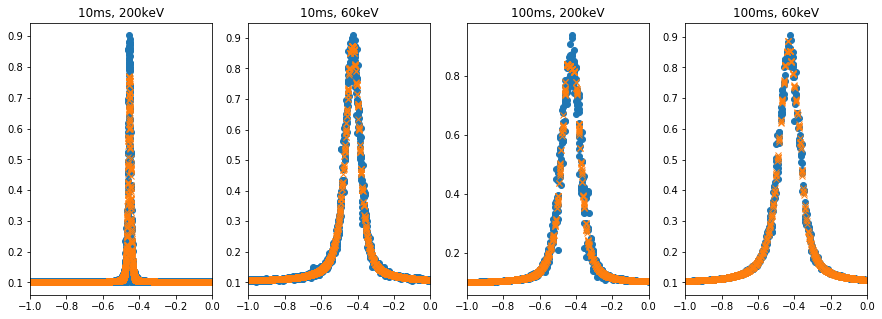

In [10]:
plt.figure(figsize=(15,5))

index10200 = np.where((train_x[:,1] == .1) & (train_x[:,2] == 2))
index1060 = np.where((train_x[:,1] == .1) & (train_x[:,2] == .6))
index100200 = np.where((train_x[:,1] == 1) & (train_x[:,2] == 2))
index10060 = np.where((train_x[:,1] == 1) & (train_x[:,2] == .6))

index10 = np.where(train_x[:,1] == .1)
index100 = np.where(train_x[:,1] == 1)

plt.subplot(141)
plt.title('10ms, 200keV')
plt.xlim([-1,0])
plt.plot(train_x[index10200,0].T, train_y[index10200],'o')
plt.plot(train_x[index10200,0].T, predictions_values[index10200], 'x')
#plt.plot(train_x[index10200,0].T, train_y[index10200],'o')

plt.subplot(142)
plt.xlim([-1,0])
plt.title('10ms, 60keV')
plt.plot(train_x[index1060,0].T, train_y[index1060],'o')
plt.plot(train_x[index1060,0].T, predictions_values[index1060], 'x')

plt.subplot(143)
plt.xlim([-1,0])
plt.title('100ms, 200keV')
plt.plot(train_x[index100200,0].T, train_y[index100200],'o')
plt.plot(train_x[index100200,0].T, predictions_values[index100200], 'x')

plt.subplot(144)
plt.xlim([-1,0])
plt.title('100ms, 60keV')
plt.plot(train_x[index10060,0].T, train_y[index10060],'o')
plt.plot(train_x[index10060,0].T, predictions_values[index10060], 'x')

plt.show()


Below, the distribution of $\chi^2$ is plotted for training over the $N_{rep}$ MC replicas.

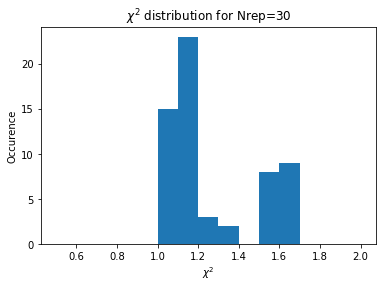

In [162]:
%run Evaluate_pseudodata.ipynb
%run Functions.ipynb
Nrep=30
plt.hist(chi2_array, bins=15, range=[0.5, 2])
plt.title('$\chi^2$ distribution for Nrep=30')
plt.xlabel('$\chi^2$')
plt.ylabel('Occurence')
plt.savefig('Data/Results/%(date)s/aaa chidistribution_%(epoch)s_Nrep=%(i)s' % {"date": d_string, "epoch": training_epochs, "i": Nrep })

plt.show()


## Residuals

In [147]:
N_train = len(train_x[:,0])

best_pred = pseudo_pred[N_train*12 :N_train*13 ]
best_y = pseudo_y[N_train*12 :N_train*13]
train_sigma = train_sigma.reshape(N_train,)

best_res = residuals(best_pred, best_y, train_sigma)

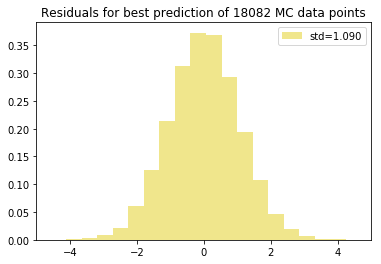

In [148]:
n, bins = np.histogram(best_res, bins=10)

mids = 0.5*(bins[1:] + bins[:-1])
probs = n / np.sum(n)

mean = np.sum(probs * mids)  
sd = np.sqrt(np.sum(probs * (mids - mean)**2))

label1 = 'std=%(std).5s' % {"std":sd}

fig = plt.hist(best_res, bins=20, density=True, color='khaki', label=label1)
plt.title('Residuals for best prediction of %(N_train)s MC data points' % {"N_train": N_train})
plt.legend([label1])

plt.xlim([-5,5])
plt.show()

## Extrapolation in energy loss

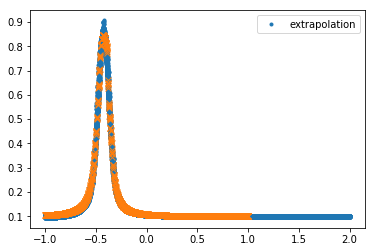

In [224]:
x_extrapol = extrapolation['dE']
prediction = extrapolation['D']
plt.plot(x_extrapol, prediction, '.', label='extrapolation')
plt.plot(train_x[index10060,0].T, predictions_values[index10060], 'x')

plt.legend()


## Interpolation in Beam Energy

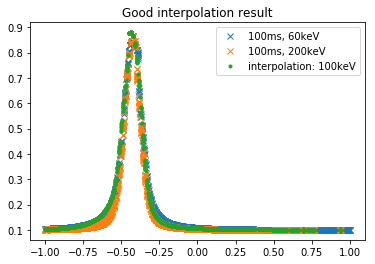

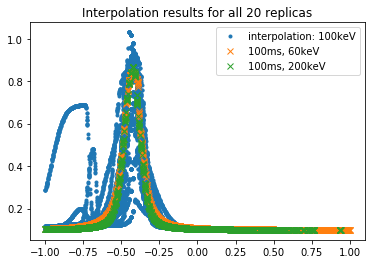

In [230]:
%run Evaluate_pseudodata.ipynb

x_interpol = interpolation['dE']

k=4
prediction_interpol = interpolation['D']
plt.plot(train_x[index10060,0].T, predictions_values[index10060], 'x', label='100ms, 60keV')
plt.plot(train_x[index100200,0].T, predictions_values[index100200], 'x', label='100ms, 200keV')
plt.plot(x_interpol[k * N_interpol : (k+1)*N_interpol], prediction_interpol[k*N_interpol :(k+1)*N_interpol], '.', label='interpolation: 100keV')
plt.title('Good interpolation result')
plt.legend()
plt.show()

plt.plot(x_interpol, prediction_interpol, '.', label='interpolation: 100keV')
plt.plot(train_x[index10060,0].T, predictions_values[index10060], 'x', label='100ms, 60keV')
plt.plot(train_x[index100200,0].T, predictions_values[index100200], 'x', label='100ms, 200keV')
plt.title('Interpolation results for all 20 replicas')
plt.legend()
plt.show()


## Write everything to report file

In [157]:
import sys
import base64

energy = 200
time = 10
nbins = 60
training_epochs = 100000

reportname = r'Reports/%(date)s_%(energy)skeV_%(time)sms_e%(epoch)s_Nrep=%(i)s.html' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
sys.stdout = open(reportname,'w')


from prettytable import PrettyTable
list1 = ['Energy:','Exposure time:','Nbins:', 'Replicas:', 'Training epochs:']
list2 = [energy, time, nbins, Nrep, training_epochs]

for x in range(0,5):
    print('%(s1)s %(s2)s <br />' % {"s1": list1[x], "s2": list2[x]}) 



In [ ]:
plot1 = r'Data/Results/%(date)s/aaa chidistribution_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
plot2 = r'Data/Results/%(date)s/aaa means-vs-means_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
plot3 = r'Data/Results/%(date)s/aaa std-vs-std_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
plot4 = r'Data/Results/%(date)s/aaa Residuals_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }

data_uri1 = base64.b64encode(open(plot1, 'rb').read()).decode('utf-8')
data_uri2 = base64.b64encode(open(plot2, 'rb').read()).decode('utf-8')
data_uri3 = base64.b64encode(open(plot3, 'rb').read()).decode('utf-8')
data_uri4 = base64.b64encode(open(plot4, 'rb').read()).decode('utf-8')
img_tag1 = '<img src="data:image/png;base64,{0}">'.format(data_uri1)
img_tag2 = '<img src="data:image/png;base64,{0}">'.format(data_uri2)
img_tag3 = '<img src="data:image/png;base64,{0}">'.format(data_uri3)
img_tag4 = '<img src="data:image/png;base64,{0}">'.format(data_uri4)

print(img_tag1)
print(img_tag2)
print(img_tag3)
print(img_tag4)